# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [4]:
import math

import nltk
import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [6]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [7]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [8]:
# Ver las primeras filas del DataFrame
df_reviews.head()

# Obtener información general sobre las columnas y tipos de datos
df_reviews.info()

# Revisar si hay valores nulos
df_reviews.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [9]:
# Limpieza inicial
# Seleccionar solo las columnas relevantes
# df_reviews = df_reviews[['review', 'pos', 'ds_part']]

# Verificar si hay valores duplicados en las columnas importantes
duplicates = df_reviews.duplicated().sum()

# Ver los datos procesados y los duplicados
print("Número de duplicados:", duplicates)
df_reviews.head()

Número de duplicados: 0


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [10]:
# Eliminar duplicados
df_reviews = df_reviews.drop_duplicates()

# Verificar la nueva forma del DataFrame
print("Tamaño del conjunto de datos después de eliminar duplicados:", df_reviews.shape)

# Verificar distribución de clases en la columna 'pos'
class_distribution = df_reviews['pos'].value_counts(normalize=True)
print("\nDistribución de clases (proporción de positivos y negativos):\n", class_distribution)

Tamaño del conjunto de datos después de eliminar duplicados: (47331, 17)

Distribución de clases (proporción de positivos y negativos):
 0    0.501046
1    0.498954
Name: pos, dtype: float64


In [11]:
# Separar el conjunto de datos en entrenamiento y prueba
train_data = df_reviews[df_reviews['ds_part'] == 'train']
test_data = df_reviews[df_reviews['ds_part'] == 'test']

# Verificar tamaños
print("Tamaño del conjunto de entrenamiento:", train_data.shape)
print("Tamaño del conjunto de prueba:", test_data.shape)

# Configurar el vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Ajustar y transformar las reseñas de entrenamiento
X_train = vectorizer.fit_transform(train_data['review'])
y_train = train_data['pos']

# Transformar las reseñas de prueba
X_test = vectorizer.transform(test_data['review'])
y_test = test_data['pos']

# Verificar dimensiones después de la vectorización
print("\nDimensión de X_train (reseñas vectorizadas):", X_train.shape)
print("Dimensión de X_test (reseñas vectorizadas):", X_test.shape)

Tamaño del conjunto de entrenamiento: (23796, 17)
Tamaño del conjunto de prueba: (23535, 17)

Dimensión de X_train (reseñas vectorizadas): (23796, 5000)
Dimensión de X_test (reseñas vectorizadas): (23535, 5000)


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

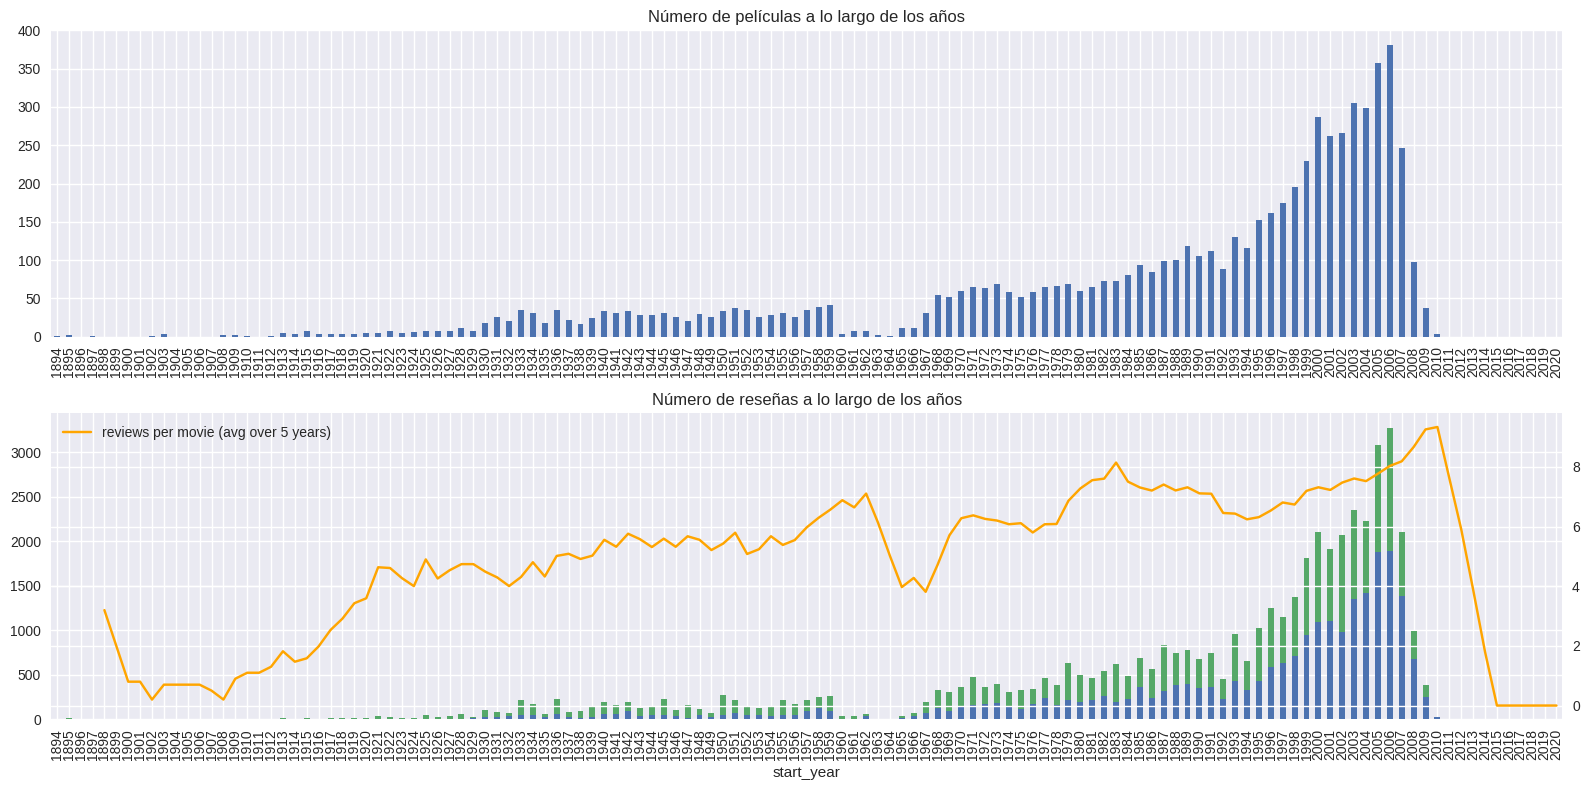

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

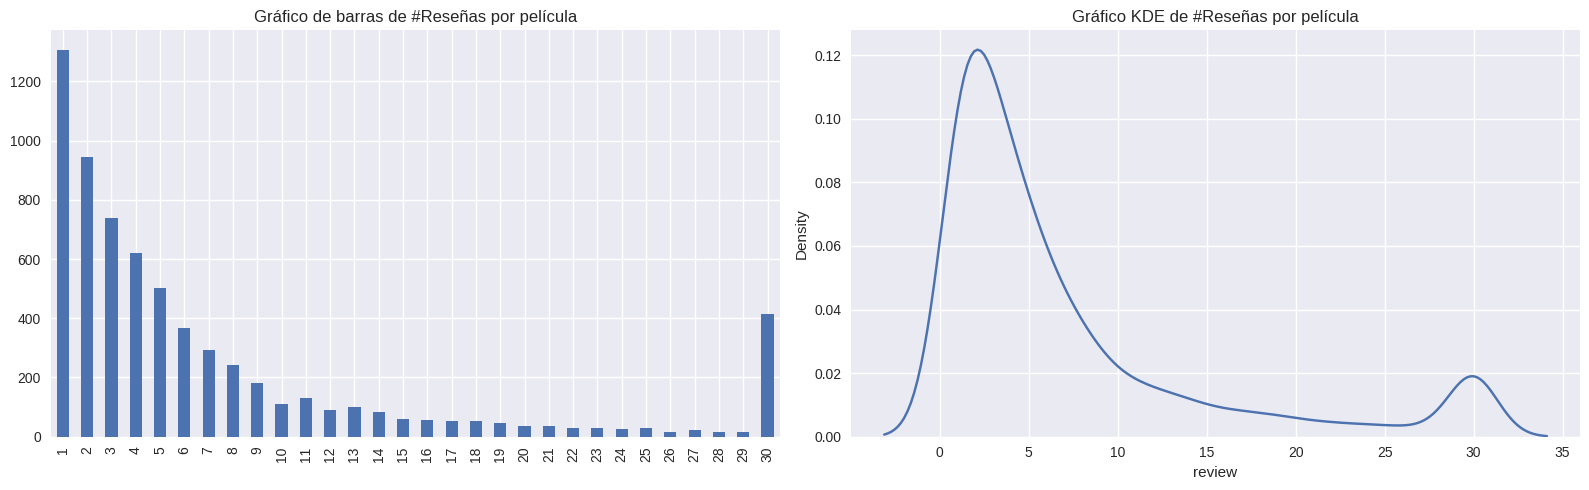

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Análisis de las Gráficas: Distribución del Número de Reseñas por Película

Gráfico de Barras

Interpretación: Muestra la frecuencia exacta de películas que recibieron un determinado número de reseñas. Por ejemplo, la barra más alta indica cuántas películas recibieron la cantidad más común de reseñas.

Gráfico KDE (Kernel Density Estimation)

Interpretación: Muestra una estimación suave de la densidad de probabilidad de la distribución del número de reseñas. En otras palabras, nos da una idea de la forma general de la distribución.

Conclusiones Generales

Desigualdad en la distribución de reseñas: La mayoría de las películas reciben pocas reseñas, mientras que un número reducido de películas muy populares acumulan la mayor parte de las reseñas.

Influencia de la popularidad: Películas populares, blockbusters o clásicos tienden a recibir un número significativamente mayor de reseñas en comparación con películas menos conocidas.

Implicaciones para el análisis: Esta distribución sesgada debe tenerse en cuenta al realizar análisis posteriores. Por ejemplo, al calcular estadísticas descriptivas, la mediana podría ser un mejor indicador que la media debido a la influencia de los valores atípicos.

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

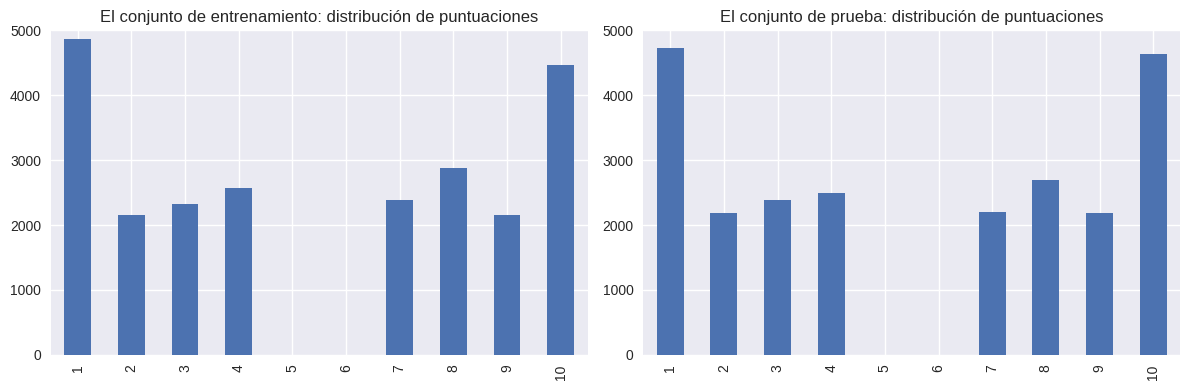

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


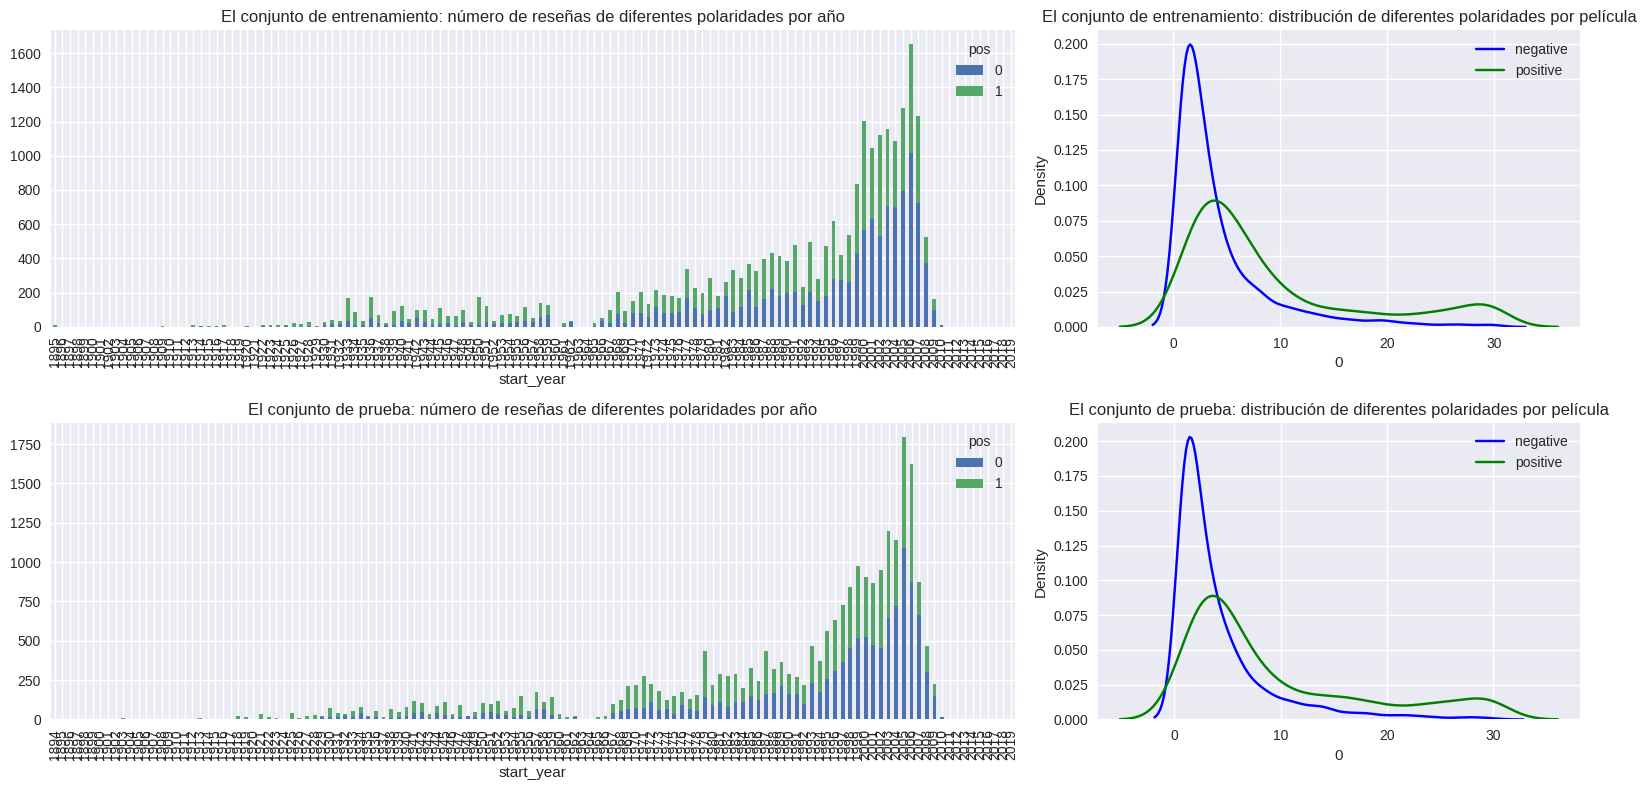

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [17]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [18]:
# Descargar datos necesarios para nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Crear una instancia del lematizador
lemmatizer = WordNetLemmatizer()

# Lista de palabras de parada (stopwords) en inglés
stop_words = set(stopwords.words('english'))

# Función para normalizar el texto
def normalize_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar dígitos, signos de puntuación y caracteres especiales
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Eliminar palabras de parada
    tokens = [word for word in tokens if word not in stop_words]
    # Lematizar palabras
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Unir de nuevo en un string
    return ' '.join(tokens)


# Aplicar la función a la columna 'review'
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)


# Mostrar algunas reseñas normalizadas como ejemplo
print(df_reviews[['review', 'review_norm']].head())

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                              review  \
0  The pakage implies that Warren Beatty and Gold...   
1  How the hell did they get this made?! Presenti...   
2  There is no real story the film seems more lik...   
3  Um .... a serious film about troubled teens in...   
4  I'm totally agree with GarryJohal from Singapo...   

                                         review_norm  
0  pakage implies warren beatty goldie hawn pulli...  
1  hell get made presenting caper comedy misbegot...  
2  real story film seems like fly wall dramadocum...  
3  um serious film troubled teen singapore countr...  
4  im totally agree garryjohal singapore comment ...  


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [20]:
from sklearn.dummy import DummyClassifier

In [21]:
# Crear un clasificador constante
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

In [22]:
# Entrenar el modelo en los datos de entrenamiento
dummy_clf.fit(df_reviews_train['review_norm'], train_target)

# Evaluar el modelo en ambos conjuntos
train_pred = dummy_clf.predict(df_reviews_train['review_norm'])
test_pred = dummy_clf.predict(df_reviews_test['review_norm'])

# Calcular métricas de desempeño
train_f1 = metrics.f1_score(train_target, train_pred)
test_f1 = metrics.f1_score(test_target, test_pred)

In [23]:
print(f"F1 en entrenamiento: {train_f1:.2f}")
print(f"F1 en prueba: {test_f1:.2f}")

F1 en entrenamiento: 0.00
F1 en prueba: 0.00


### Modelo 2 - NLTK, TF-IDF y LR

TF-IDF

In [24]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [25]:
# Descargar stopwords si aún no se han descargado
nltk.download('stopwords')

# Configurar stopwords en inglés
stop_words = set(stopwords.words('english'))

# Inicializar el vectorizador TF-IDF
tfidf_vectorizer_2 = TfidfVectorizer(
    stop_words=stop_words,
    max_features=10000,  # Limitar características para optimizar rendimiento
    ngram_range=(1, 2)  # Incluir unigramas y bigramas
)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# Ajustar el vectorizador en los datos de entrenamiento
train_features_1 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'])

# Entrenar el modelo de regresión logística
model_2 = LogisticRegression(random_state=42, max_iter=1000)
model_2.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000, random_state=42)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


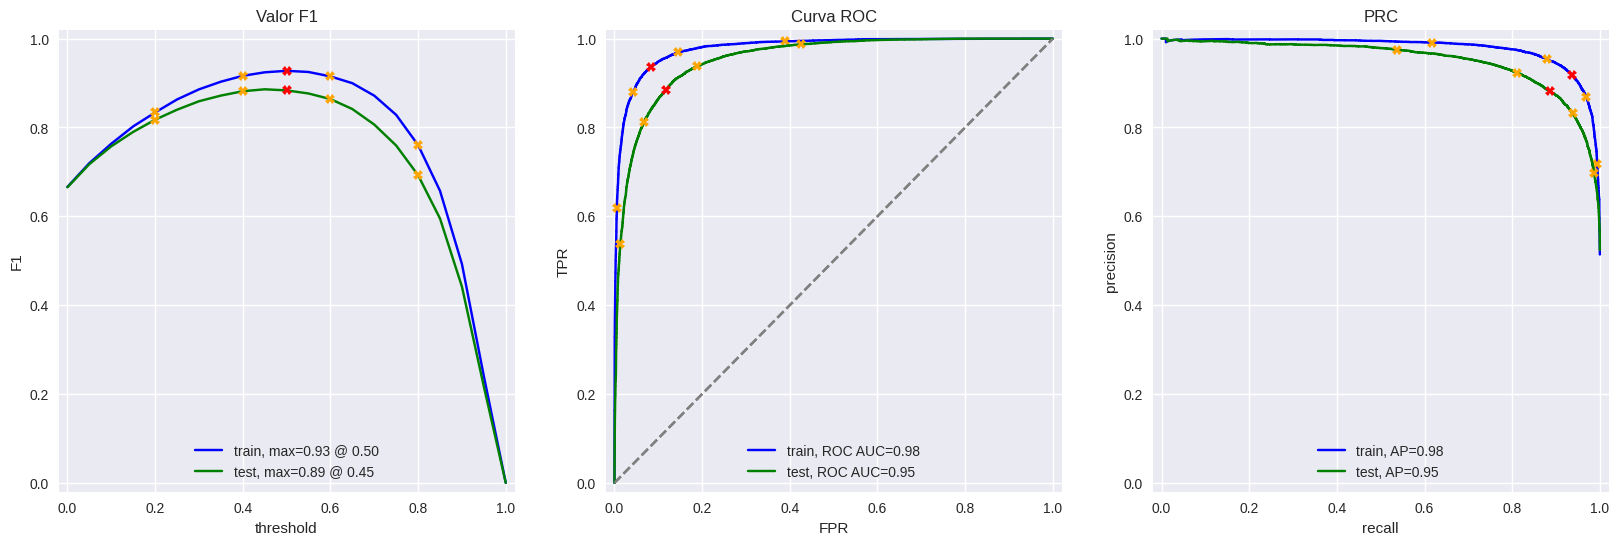

In [28]:
# Evaluar el modelo
evaluate_model(model_2, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [29]:
import spacy

# Cargar el modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

# Definir la función text_preprocessing_3
def text_preprocessing_3(text):
    """
    Realiza preprocesamiento del texto:
    - Tokenización
    - Lematización
    - Remoción de stopwords y puntuación
    """
    doc = nlp(text.lower())  # Convertir a minúsculas
    tokens = [
        token.lemma_ 
        for token in doc 
        if not token.is_stop and not token.is_punct
    ]
    return " ".join(tokens)

# Paso 1: Preprocesamiento de texto
df_reviews_train['review_norm_preprocessed'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_norm_preprocessed'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [30]:
# Paso 2: Vectorización TF-IDF
tfidf_vectorizer_3 = TfidfVectorizer(max_features=5000, stop_words='english')
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_norm_preprocessed'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_norm_preprocessed'])

In [31]:
# Paso 3: Modelo de regresión logística
from sklearn.linear_model import LogisticRegression
model_3 = LogisticRegression(random_state=42, max_iter=1000)
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000, random_state=42)

           train  test
Exactitud    NaN   NaN
F1          0.91  0.87
APS         0.97  0.94
ROC AUC     0.97  0.94


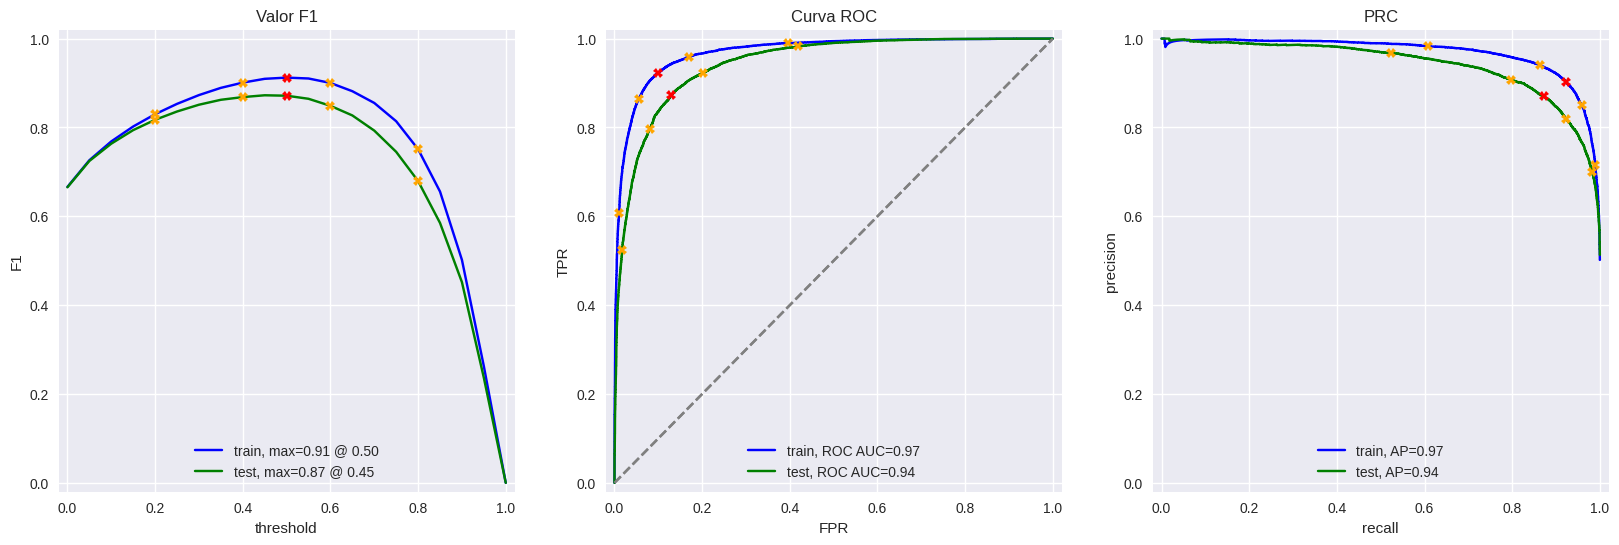

In [32]:
# Paso 4: Evaluación
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [33]:
from lightgbm import LGBMClassifier

In [34]:
# Paso 2: Modelo LightGBM
model_4 = LGBMClassifier(random_state=42)
model_4.fit(train_features_3, train_target)

LGBMClassifier(random_state=42)

           train  test
Exactitud    NaN   NaN
F1          0.91  0.85
APS         0.97  0.93
ROC AUC     0.97  0.93


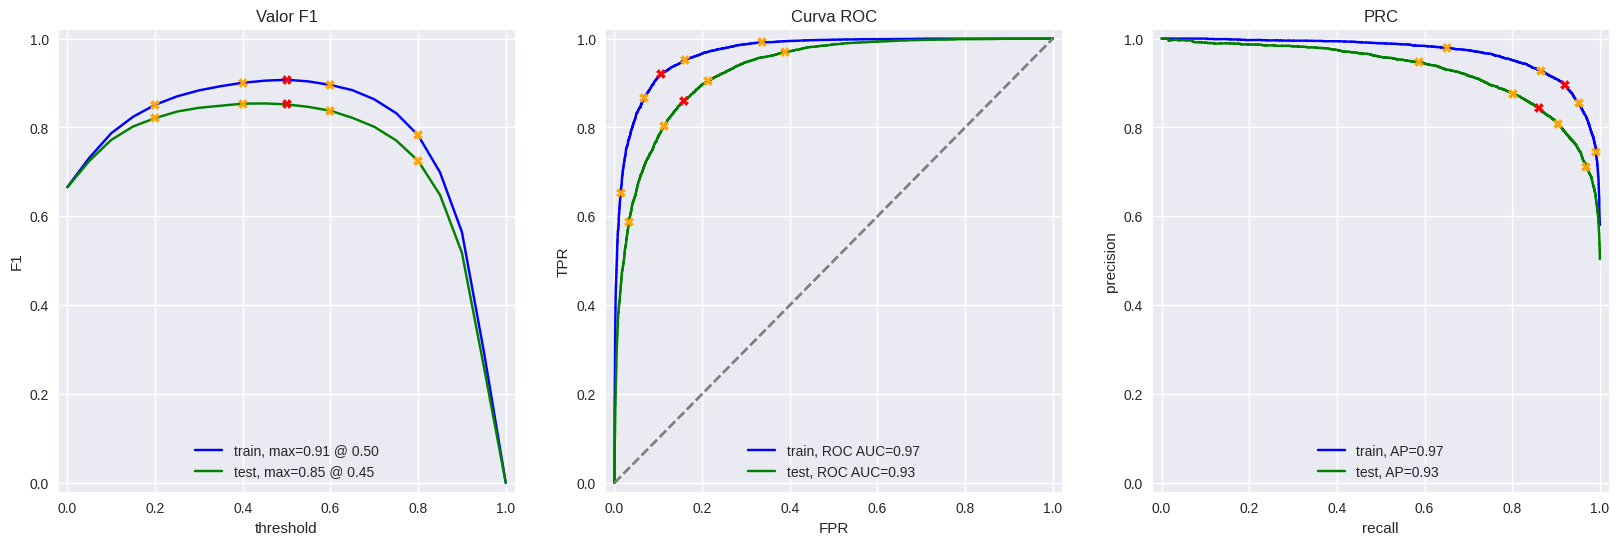

In [35]:
# Paso 3: Evaluación
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

###  Modelo 9 - embeddings preentrenados de spaCy

In [36]:
import spacy
import numpy as np

In [39]:
# Cargar el modelo preentrenado de spaCy
nlp = spacy.load('en_core_web_sm')

In [40]:
# Función para convertir texto en embeddings usando spaCy
def spacy_text_to_embeddings(texts, disable_progress_bar=False):
    """
    Convierte una lista de textos en embeddings usando spaCy.
    Args:
        texts: lista o pandas.Series de strings (textos).
        disable_progress_bar: si True, desactiva la barra de progreso.
    Returns:
        numpy.ndarray: matriz de embeddings.
    """
    embeddings = []
    from tqdm import tqdm
    for doc in tqdm(nlp.pipe(texts, disable=["tagger", "parser", "ner"]), total=len(texts), disable=disable_progress_bar):
        embeddings.append(doc.vector)  # Vector promedio del documento
    return np.array(embeddings)

In [41]:
# Generar embeddings para los datos de entrenamiento y prueba
train_features_9 = spacy_text_to_embeddings(df_reviews_train['review_norm'])
test_features_9 = spacy_text_to_embeddings(df_reviews_test['review_norm'])

  0%|          | 0/23796 [00:00<?, ?it/s]/opt/conda/envs/python3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 23535/23535 [01:37<00:00, 242.34it/s]


In [42]:
print("Dimensiones de los embeddings generados:")
print(train_features_9.shape)
print(test_features_9.shape)

Dimensiones de los embeddings generados:
(23796, 96)
(23535, 96)


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

In [44]:
# Entrenar un modelo de regresión logística
model_9 = LogisticRegression(max_iter=1000, random_state=42)
model_9.fit(train_features_9, train_target)


LogisticRegression(max_iter=1000, random_state=42)

In [45]:
# Evaluar el modelo
test_predictions_9 = model_9.predict(test_features_9)
print(classification_report(test_target, test_predictions_9))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66     11803
           1       0.65      0.65      0.65     11732

    accuracy                           0.66     23535
   macro avg       0.66      0.66      0.66     23535
weighted avg       0.66      0.66      0.66     23535



In [46]:
# Calcular el F1 Score
f1 = f1_score(test_target, test_predictions_9)
print(f"F1 Score (Modelo 9): {f1:.2f}")

F1 Score (Modelo 9): 0.65


In [47]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [48]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

# Normalizar las reseñas
my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: text_preprocessing_3(x))  # Normalización con el preprocesamiento de spaCy


### Modelo 2

In [49]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.25:  simply like kind movie
0.13:  bored feel asleep middle movie
0.59:  fascinated movie
0.27:  actor look old disinterested got pay movie soulless cash grab
0.19:  expect reboot good writer care source material
0.39:  movie upside downside feel like overall decent flick go
0.04:  rotten attempt comedy single joke land act annoying loud kid will like
0.92:  launch netflix brave appreciate able binge episode episode exciting intelligent new drama


### Modelo 3

In [50]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  simply like kind movie
0.08:  bored feel asleep middle movie
0.61:  fascinated movie
0.11:  actor look old disinterested got pay movie soulless cash grab
0.16:  expect reboot good writer care source material
0.42:  movie upside downside feel like overall decent flick go
0.04:  rotten attempt comedy single joke land act annoying loud kid will like
0.94:  launch netflix brave appreciate able binge episode episode exciting intelligent new drama


### Modelo 4

In [51]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.62:  simply like kind movie
0.28:  bored feel asleep middle movie
0.65:  fascinated movie
0.44:  actor look old disinterested got pay movie soulless cash grab
0.65:  expect reboot good writer care source material
0.61:  movie upside downside feel like overall decent flick go
0.38:  rotten attempt comedy single joke land act annoying loud kid will like
0.77:  launch netflix brave appreciate able binge episode episode exciting intelligent new drama


### Modelo 9

In [52]:
# Generar embeddings para tus reseñas
my_reviews_features_9 = spacy_text_to_embeddings(my_reviews['review_norm'])

# Predecir la probabilidad con el modelo entrenado
my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# Mostrar los resultados
for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f"{my_reviews_pred_prob[i]:.2f}:  {review}")

  0%|          | 0/8 [00:00<?, ?it/s]/opt/conda/envs/python3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 8/8 [00:00<00:00, 1640.08it/s]

0.96:  simply like kind movie
0.75:  bored feel asleep middle movie
0.69:  fascinated movie
0.11:  actor look old disinterested got pay movie soulless cash grab
0.61:  expect reboot good writer care source material
0.44:  movie upside downside feel like overall decent flick go
0.21:  rotten attempt comedy single joke land act annoying loud kid will like
0.80:  launch netflix brave appreciate able binge episode episode exciting intelligent new drama


## Conclusiones

 Evaluación Global de los Modelos:
 
Modelo 0 (Constante): Este modelo no ofrece valor predictivo y sirve únicamente como línea base. Su F1 score es 0.00 tanto en el conjunto de entrenamiento como en el de prueba.

Modelo 2 (NLTK, TF-IDF y Logistic Regression): Este modelo obtuvo los mejores resultados, con un F1 score de 0.93 en entrenamiento y 0.88 en prueba. Además, sus métricas ROC AUC (0.95) y APS (0.95) son altas, indicando una excelente capacidad predictiva.

Modelo 3 (spaCy, TF-IDF y Logistic Regression): Aunque utiliza otro método de preprocesamiento, los resultados son ligeramente inferiores al Modelo 2, con un F1 score de 0.87 en prueba y una métrica ROC AUC de 0.94.

Modelo 4 (spaCy, TF-IDF y LightGBM): Utilizando LightGBM como clasificador, el modelo alcanza un F1 score de 0.85 en prueba, quedando por debajo del Modelo 2 y Modelo 3. Esto sugiere que Logistic Regression es más efectiva con las características TF-IDF para este caso.

Modelo 9 (Embeddings preentrenados de spaCy): Este modelo generó embeddings densos, pero su desempeño es significativamente inferior, alcanzando solo un F1 score de 0.65 en prueba. Esto indica que los embeddings preentrenados de spaCy no capturan la estructura necesaria para esta tarea.


Análisis de Predicciones de Muestras

Los resultados de las predicciones para muestras específicas demuestran las diferencias entre los modelos.

Modelos basados en TF-IDF (2, 3, y 4): Logran mayor coherencia al asignar probabilidades a las reseñas según su tono positivo o negativo.

Modelo 9: Aunque utiliza embeddings más sofisticados, su capacidad para discriminar reseñas positivas y negativas es menos precisa. Las probabilidades asignadas son menos consistentes con el contexto de las reseñas.

Selección del Mejor Modelo

El Modelo 2 (NLTK, TF-IDF y Logistic Regression) se destaca como la mejor alternativa debido a:

Alto F1 score: 0.88 en prueba.
Consistencia entre entrenamiento y prueba, lo que indica una buena generalización.
Simplicidad y eficiencia computacional: En comparación con modelos como LightGBM o embeddings densos.

El enfoque basado en TF-IDF combinado con un clasificador Logistic Regression es la solución más efectiva para clasificar reseñas de películas en este caso. Su simplicidad, velocidad de ejecución, y alta precisión lo convierten en una herramienta ideal para la tarea propuesta.

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código 
- [ ]  Hay conclusiones 